In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import pandas as pd
import numpy as np
import seaborn as sln
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import re
% matplotlib inline

In [0]:
data=pd.read_csv('/content/drive/My Drive/fake_or_real_news.csv')

In [0]:
data.shape

(6335, 4)

In [0]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [0]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem import WordNetLemmatizer
stop=list(set(stopwords.words('english')))+list(string.punctuation)

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
tweet=TweetTokenizer(preserve_case=True, reduce_len=True,strip_handles=True)
lemma=WordNetLemmatizer()

In [0]:
def pre_process(text):
    
    

    text=re.sub("</?.*?>"," <> ",text)
 
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

In [0]:
# start preprocessing of data
def processing(df):
  df['text_comb']=df['title']+''+df['text']
  df['text_comb']=df['text_comb'].apply(lambda x:pre_process(x))
  df['text_comb']=df['text_comb'].apply(lambda x:' '.join(x.lower() for x in x.split()))
  df['text_comb']=df['text_comb'].apply(lambda x:' '.join(x for x in tweet.tokenize(x) if x not in stop))
  df['text_comb']=df['text_comb'].apply(lambda x:' '.join(lemma.lemmatize(x) for x in x.split()))
  return df

In [0]:
data=processing(data)

In [0]:
data.head()

,Unnamed: 0,title,text,label,text_comb
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,smell hillary feardaniel greenfield shillman j...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,watch exact moment paul ryan committed politic...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,kerry go paris gesture sympathyu secretary sta...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,bernie supporter twitter erupt anger dnc tried...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,battle new york primary mattersit primary day ...


In [0]:
data['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [0]:
real_df=data[data['label']=='REAL'][['Unnamed: 0','text_comb']]
fake_df=data[data['label']=='FAKE'][['Unnamed: 0','text_comb']]

In [0]:
real_df.shape

(3171, 2)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tfid=TfidfVectorizer(smooth_idf=True,use_idf=True)

In [0]:
real_tf_df=tfid.fit_transform(real_df['text_comb'])

In [0]:
fake_tf_df=tfid.fit_transform(fake_df['text_comb'])

In [0]:
feature_names = tfid.get_feature_names()

In [0]:
def divide(l, n):
  for i in range(0, len(l), n):
    yield l[i:i + n]

IndexError: ignored

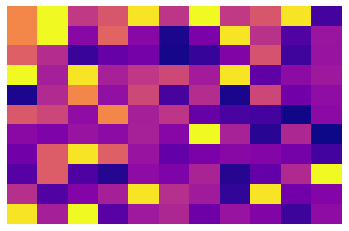

In [0]:
for num,text in zip(fake_df['index'],fake_df['text_comb']):
  doc = num
  feature_index = real_tf_df[doc,:].nonzero()[1]
  tfidf_scores = zip(feature_index, [real_tf_df[doc, x] for x in feature_index])
  score_dict={}
  for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    score_dict[w]=s
  tf_score_list=[]
  for word in fake_df['text_comb'][num].split():
    tf_score_list.append(score_dict.get(word))
  tf_score_list=[score for score in tf_score_list if score!=None]
  top_121=tf_score_list[:121]
  n = 11
  x = list(divide(top_121, n)) 
  data = np.asarray(x) 
  try:

    log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
    pol = sln.heatmap(
              data,
              cmap = 'plasma',
              norm = log_norm,
              xticklabels = False, #Disabling x-axis
              yticklabels = False, #Disabling y-axis
              cbar=False #Disabling colour bar
          ) 
    fig = pol.get_figure()
    fig.savefig(f'/content/drive/My Drive/fake_news/fake/fake{num}') 
  except:
    pass 


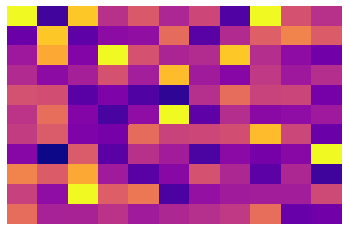

In [0]:
 pol = sln.heatmap(
            data,
            cmap = 'plasma',
            norm = log_norm,
            xticklabels = False, #Disabling x-axis
            yticklabels = False, #Disabling y-axis
            cbar=False #Disabling colour bar
        ) 

In [0]:
fake_df=real_df.reset_index()

###### This is image classification part

In [0]:
from operator import itemgetter
from fastai.vision import *

In [0]:
classes = ['fake', 'real']

In [0]:
path='/content/drive/My Drive/fake_new/'

In [0]:
for folder in ('fake','real'):
  verify_images(path+folder, delete=True, max_size=1200)

In [0]:
#Note:
#1) Data Augmentation has been explicitely been turned off since any changes to the plots will change the underlying meaning
#2) A random validation set of 20% is used
np.random.seed(42)

data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)



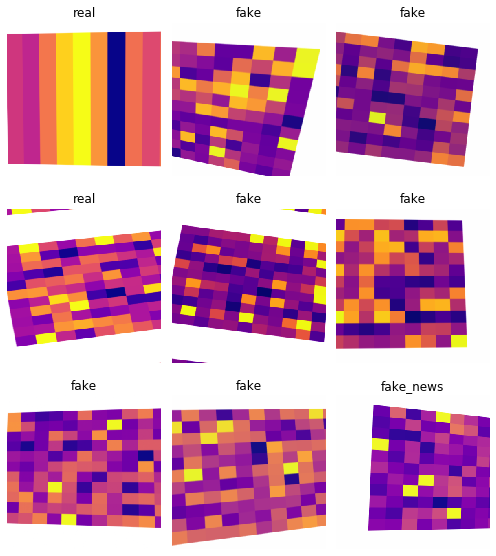

In [0]:
data.show_batch(rows=3, figsize=(7, 8))

In [0]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 62.5MB/s]


In [0]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.522326,1.617086,0.577540,02:48
1,1.258880,1.351076,0.550802,01:30
2,1.036563,1.185869,0.490196,01:31
3,0.880298,1.216318,0.474153,01:31


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


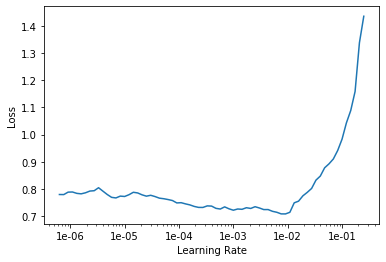

In [0]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.694614,1.009658,0.388592,01:33
1,0.604895,2.100458,0.638146,01:33
2,0.554947,0.754253,0.324421,01:33
3,0.524202,0.787476,0.342246,01:34


In [0]:
learn.save('/content/drive/My Drive/fake_new/text_to_image')